In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib
from mpl_toolkits import mplot3d
from multiprocessing import Pool
import pandas as pd
from numpy.random import random

from scipy.optimize import fsolve
from scipy import interpolate
from scipy.integrate import quad
from scipy.integrate import trapz
from scipy import constants

import os
import sys

from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
#from astropy.io import fits
from astropy.table import Table
import astropy 
from ligo.skymap.io import fits
from ligo.skymap.postprocess import find_greedy_credible_levels

from tqdm import tqdm
from multiprocessing import Pool
import time
from numba import njit
###########################
# CONSTANTS
###########################
H0GLOB= 67#69.32#67.9 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoplank = Planck18
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
#H0=cosmoplank.H(0).value
#h=H0GLOB/100
#geometrization of masses
#Msun=(1.98892)*(10**30)
#solarmass_to_m=(constants.G*Msun)/((constants.c)**2)#G/c^2
#Mpc_to_m=3.08567758128*(10**22) #this will be used later
#-------miscellanea-----------------------

        Use get instead. [ligo.skymap.postprocess.cosmology]


In [31]:
def random_VMF ( mu , kappa , size = None ) :
# https://hal.science/hal-04004568/
# parse input parameters
    n = 1 if size is None else np.product(size)
    shape = () if size is None else tuple(np.ravel(size))
    mu = np.asarray(mu)
    mu = mu/np.linalg.norm(mu)
    (d ,) = mu.shape
    # zcomponent:radial samples perpendicular to mu
    z = np.random.normal(0,1,(n,d))
    z /= np.linalg.norm(z,axis=1,keepdims=True)
    z = z - (z@mu[:,None])*mu[None, :]
    z /= np.linalg.norm(z,axis =1,keepdims=True )
    # sample angles ( in cos and sin form )
    cos = random_VMF_angle(d,kappa,n)
    sin = np.sqrt(1-cos ** 2)
    # combine angles with the z component
    x = z * sin[ : , None] + cos[ : , None] * mu[None , : ]
    return x .reshape((*shape,d))
def random_VMF_angle(d:int , k:float, n:int ) :
    alpha = (d - 1)/2
    t0 = r0 = np.sqrt(1 + (alpha / k)** 2) - alpha/k
    log_t0 = k*t0+(d-1)*np.log(1 - r0*t0)
    found = 0
    out = [ ]
    while found < n :
        m = min(n,int(( n - found ) * 1.5 ))
        t = np.random.beta(alpha,alpha,m )
        t = 2 * t - 1
        t = (r0 + t) / (1 + r0*t)
        log_acc = k*t +(d - 1)*np.log (1 - r0 * t) - log_t0
        t = t[np.random.random(m) < np.exp( log_acc )]
        out.append(t)
        found += len(out[ - 1 ])
    return np.concatenate(out) [:n]

In [3]:
#Gaussian Distribution on S^3
def AngDist_rad(phi0,theta0,phi1,theta1):
    tmp=np.sin(theta0)*np.sin(theta1)+(np.cos(theta0)*np.cos(theta1))*np.cos(phi0-phi1)
    return np.arccos(tmp)
@njit
def sphere_uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    #meanvec=(mux,muy)
    meanvec=np.asarray((np.sin(mux)*np.cos(muy),np.sin(mux)*np.sin(muy),np.cos(mux)))
    norm=np.sqrt(np.sum(meanvec**2))
    meanvec=meanvec/norm
    
    #var=(x,y)
    var=np.asarray((np.sin(x)*np.cos(y),np.sin(x)*np.sin(y),np.cos(x)))
    #norm=np.sqrt(np.dot(var,var))
    norm=np.sqrt(np.sum(var**2))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.sum(diff**2))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    norm=np.sqrt(2*np.pi)*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    #ret=np.exp(-1/2*(xfactor+yfactor))
    return ret
@njit
def sphere_uncorr_gauss_vec(x_vec,mu_vec,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    meanvec=mu_vec
    norm=np.sqrt(np.sum(meanvec**2))
    meanvec=meanvec/norm

    var=x_vec
    norm=np.sqrt(np.sum(var**2))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.sum(diff**2))

    norm=np.sqrt(1/(2*np.pi*sigy*sigy))**3
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))/norm

    return ret
def sphere_uncorr_gauss_hp(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    #meanvec=(mux,muy)
    meanvec=hp.ang2vec(mux,muy)
    #meanvec=np.asarray((1,mux,muy))
    norm=np.sqrt(np.sum(meanvec**2))
    meanvec=meanvec/norm
    
    #var=(x,y)
    var=hp.ang2vec(x,y)
    #var=np.asarray((1,x,y))
    #norm=np.sqrt(np.dot(var,var))
    norm=np.sqrt(np.sum(var**2))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.sum(diff**2))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    norm=np.sqrt(2*np.pi)*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    #ret=np.exp(-1/2*(xfactor+yfactor))
    return ret
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf

def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples
def phi2RA(phi):
    ret=np.rad2deg(phi)
    return ret

def theta2DEC(theta):
    ret=np.rad2deg(0.5*np.pi-theta)
    return ret

def RA2phi(RA):
    ret=np.deg2rad(RA)
    return ret

def DEC2theta(DEC):
    ret=0.5 * np.pi - np.deg2rad(DEC)
    return ret
def angdist(d1,d2,r1,r2):
    tmp=np.sin(d1)*np.sin(d2)+np.cos(d1)*np.cos(d2)*np.cos(r1-r2)
    ret=np.arccos(tmp)
    return ret

In [4]:
#target_dist= lambda r: (r/r0)**(gamma)

#values=return_samples(target_dist,rmin,rmax,1000000)

In [5]:
phi_00=np.pi/3
theta_00=np.pi/4

phi_01=np.pi/2
theta_01=np.pi/8

In [6]:
nside=1024#1024#512
npix = hp.nside2npix(nside)
vec_00 = hp.ang2vec(theta_00, phi_00)
norm_00=np.sqrt(np.sum(vec_00**2))
vec_00=vec_00/norm_00
vec_01 = hp.ang2vec(theta_01, phi_01)
norm_01=np.sqrt(np.sum(vec_01**2))
vec_01=vec_01/norm_01
print('vec_00={}\nvec_01={}'.format(vec_00,vec_01))

vec_00=[0.35355339 0.61237244 0.70710678]
vec_01=[2.34326020e-17 3.82683432e-01 9.23879533e-01]


In [7]:
recovered_00=hp.vec2ang(vec_00)
recovered_01=hp.vec2ang(vec_01)
print('recovered_00={},theta={},phi={}\nrecoverd_01={},theta={},phi={}'
      .format(recovered_00,theta_00,phi_00,recovered_01,theta_01,phi_01))

recovered_00=(array([0.78539816]), array([1.04719755])),theta=0.7853981633974483,phi=1.0471975511965976
recoverd_01=(array([0.39269908]), array([1.57079633])),theta=0.39269908169872414,phi=1.5707963267948966


In [8]:
phi_sum=phi_00+phi_01
theta_sum=theta_00+theta_01
vec_sum = hp.ang2vec(theta_sum, phi_sum)
print('vec_sum={}'.format(vec_sum))

vec_sum=[-0.80010315  0.46193977  0.38268343]


In [9]:
recovered_sum=hp.vec2ang(vec_sum)
print('recovered_sum={},theta={},phi={}'
      .format(recovered_sum,theta_sum,phi_sum))

recovered_sum=(array([1.17809725]), array([2.61799388])),theta=1.1780972450961724,phi=2.617993877991494


# Passo 2: Centro in 0 e calcolo pesi

In [111]:
Omega_90=20
radius_deg= np.sqrt(Omega_90/np.pi)
sigma90=radius_deg/np.sqrt(2)
sigma_deg=sigma90/(1.511*1)#1.6448536269514
circle_deg=6*sigma_deg
sigma_theta=np.radians(sigma_deg)
sigma_phi=np.radians(sigma_deg)
radius_rad=np.radians(circle_deg)
conc=1/sigma_phi**2

In [112]:
thetamin=np.pi/4-6*sigma_theta
thetamax=np.pi/4+6*sigma_theta
arc_min=np.cos(thetamin)
arc_max=np.cos(thetamax)

In [113]:
Npoints=1_00_000_000
all_phi =np.random.uniform(np.pi/4-6*sigma_phi,np.pi/4+6*sigma_phi,Npoints)
costheta =np.random.uniform(arc_min,arc_max,Npoints)
all_theta = np.arccos(costheta)
all_vec=hp.ang2vec(all_theta,all_phi)

In [114]:
#def convert_to_vec(params):
#    theta, phi = params
#    return hp.ang2vec(theta, phi)
# Crea una lista di tuple da passare alla funzione
#all_angles = list(zip(all_theta, all_phi))
#n_processes = 13  
#with Pool(processes=n_processes) as pool:
#    results = list(tqdm(pool.imap(convert_to_vec, all_angles), total=len(all_angles)))
#all_vec = np.array(results)
# Re-adding the modified code with chunksize parameter for multiprocessing


def convert_to_vec(params):
    # Convert spherical coordinates to a vector
    theta, phi = params
    return hp.ang2vec(theta, phi)

def parallel_convert_to_vec(all_angles, n_processes=13, chunksize=100):
    """
    Convert lists of angles to vectors in parallel.

    Args:
        all_angles (list of tuple): List of (theta, phi) tuples.
        n_processes (int): Number of parallel processes to use.
        chunksize (int): Number of tasks allocated to each worker process at a time.

    Returns:
        np.ndarray: Array of vectors converted from spherical coordinates.
    """
    with Pool(processes=n_processes) as pool:
        results = list(tqdm(pool.imap(convert_to_vec, all_angles, chunksize=chunksize), total=len(all_angles)))
    return np.array(results)

# The function call should look like this (commented out for demonstration):
#all_vec = parallel_convert_to_vec(all_angles, n_processes=13, chunksize=10000)


In [115]:
#(x,y,mux,muy,sigx,sigy)
mux=np.pi/4
muy=np.pi/4
ref_vec=hp.ang2vec(mux,muy)
ref_norm=np.sqrt(np.sum(ref_vec**2))
ref_vec=ref_vec/ref_norm
sigx=sigma_phi
sigy=sigma_phi

In [116]:
pesi=np.zeros(len(all_vec))
for i in tqdm(range(len(all_vec))):
    pesi[i]=sphere_uncorr_gauss_vec(all_vec[i],ref_vec,sigx)
pesi_normed=pesi/np.sum(pesi)

100%|███████████████████████████████████████████████████████| 100000000/100000000 [02:07<00:00, 783868.48it/s]


In [117]:
#sopra i 100_000_000 dovrebbe essere più volece, ma non è detto 
from functools import partial


# This is a wrapper function for applying 'sphere_uncorr_gauss_vec' over a single argument,
# since the other arguments (ref_vec, sigx) do not change across the parallel calls.
def parallel_worker(vec, ref_vec, sigx):
    return sphere_uncorr_gauss_vec(vec, ref_vec, sigx)

def compute_weights(all_vec, ref_vec, sigx, num_processes=None):
    # Create a partial function with fixed reference vector and sigma
    worker_func = partial(parallel_worker, ref_vec=ref_vec, sigx=sigx)

    # Initialize multiprocessing Pool
    with Pool(processes=num_processes) as pool:
        # Map 'sphere_uncorr_gauss_vec' over 'all_vec' with a progress bar
        # 'chunksize' can be adjusted for optimization based on the size of 'all_vec' and the task's nature
        result = list(tqdm(pool.imap(worker_func, all_vec, chunksize=1000_000), total=len(all_vec)))

    # Normalize the weights
    pesi_normed = np.array(result) / np.sum(result)
    return pesi_normed

# The actual function call would look like this:
#pesi_normed = compute_weights(all_vec, ref_vec, sigy, num_processes=13)
# Note: The 'num_processes' parameter can be adjusted based on your machine's capabilities.

# For now, we will comment out the actual function call:
#pesi_normed = compute_weights(all_vec, ref_vec, sigx, num_processes=13)


Text(0.5, 0, '$tmp$')

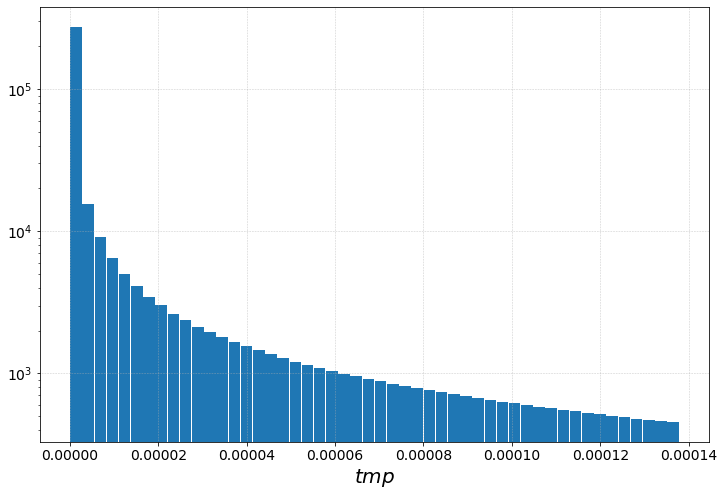

In [118]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
hist_min=np.min(pesi)
hist_max=np.max(pesi)
nbins=50

#plt.yscale('log', nonpositive='clip')
#plt.xscale('log', nonpositive='clip')
(n_pesi, bins_pesi, patches)=ax.hist(pesi,bins=nbins,rwidth=0.95,density=True,log=True)
#(n_sca, bins_sca, patches)=ax.hist(alldl_sca,bins=nbins,range=(dlinf_sca,dlsup_sca),rwidth=0.95,alpha=0.5)
centers=bins_pesi[:-1]
centers=centers+(bins_pesi[1]-bins_pesi[0])/2
#ax.scatter(centers,n_pesi,c='r',marker='x')
ax.set_xlabel(r'$tmp$', fontsize=20)

In [119]:
idx_temp=np.array(range(len(all_vec)))
mysize=4_000_000

In [120]:
all_idx=np.random.choice(idx_temp,mysize,replace=False,p=pesi_normed)

In [121]:
extracted=all_vec[all_idx]
extracted_theta=np.zeros(len(all_idx))
extracted_phi=np.zeros(len(all_idx))
norma=np.zeros(len(all_idx))
#new=extracted-ref_vec
#normed=[]
#for i in tqdm(range(len(all_idx))):
#    norma=np.sqrt(np.sum(extracted[i]**2))
extracted_theta,extracted_phi=hp.vec2ang(extracted)

In [122]:
vec_fromgit=random_VMF (ref_vec , conc , size = 40_000_000)
git_theta,git_phi=hp.vec2ang(vec_fromgit)

Text(0.5, 0, '$\\Delta\\phi$')

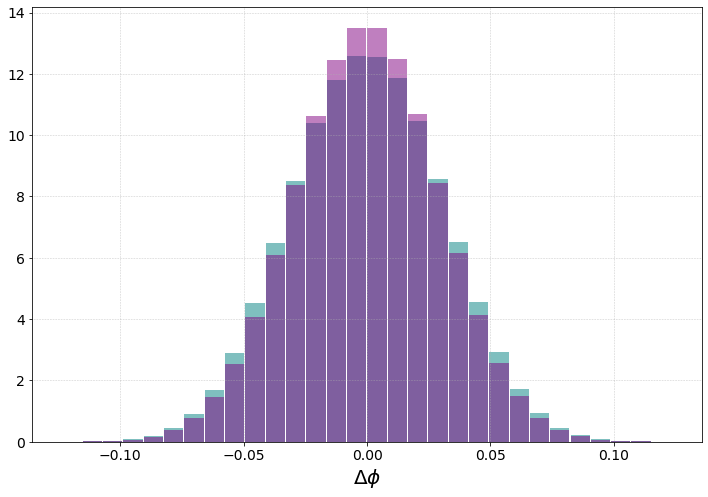

In [123]:
myphi=extracted_phi-np.mean(extracted_phi)
my_gitphi=git_phi-np.mean(git_phi)
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
hist_min=np.min(myphi)
hist_max=np.max(myphi)

nbins=30
(n10_tot, bins10_tot, patches10)=ax.hist(myphi,bins=nbins,range=(hist_min,hist_max),rwidth=0.95,density=True,color='teal',alpha=0.5)
#(n_sca, bins_sca, patches)=ax.hist(alldl_sca,bins=nbins,range=(dlinf_sca,dlsup_sca),rwidth=0.95,alpha=0.5)
#hist_min=np.min(my_gitphi)
#hist_max=np.max(my_gitphi)
(n10_tot, bins10_tot, patches10)=ax.hist(my_gitphi,bins=nbins,range=(hist_min,hist_max),rwidth=0.95,density=True,color='purple',alpha=0.5)
ax.set_xlabel(r'$\Delta\phi$', fontsize=20)

In [124]:
print('mean={} center={}'.format(np.mean(extracted_phi),muy))
#print(np.mean(myphi))
print('std={} std a mano={}'.format(np.std(myphi),sigx))


print('mean={} center={}'.format(np.mean(git_phi),muy))
#print(np.mean(myphi))
print('std={} std a mano={}'.format(np.std(my_gitphi),sigx))

print('Asimmetria di Pearson={}'.format(3*(np.mean(git_phi)-np.median(git_phi))/(np.std(git_phi))))

mean=0.7853756170789638 center=0.7853981633974483
std=0.030465195896125185 std a mano=0.02060810065592297
mean=0.7854003118570629 center=0.7853981633974483
std=0.029159384229092537 std a mano=0.02060810065592297
Asimmetria di Pearson=0.0005393090128611126


Text(0.5, 0, '$\\Delta\\cos(\\theta)$')

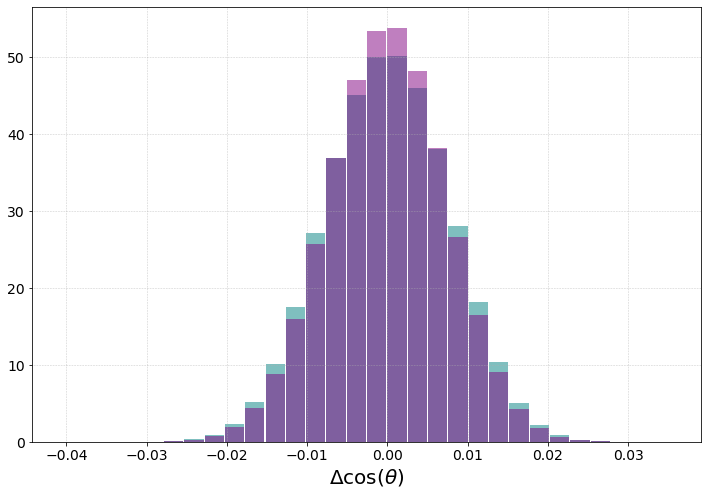

In [90]:
mycostheta=np.cos(extracted_theta)-np.mean(np.cos(extracted_theta))
mygitcosteha=np.cos(git_theta)-np.mean(np.cos(git_theta))
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
hist_min=np.min(mycostheta)
hist_max=np.max(mycostheta)

nbins=30
(n10_tot, bins10_tot, patches10)=ax.hist(mycostheta,bins=nbins,range=(hist_min,hist_max),rwidth=0.95,density=True,color='teal',alpha=0.5)
#(n_sca, bins_sca, patches)=ax.hist(alldl_sca,bins=nbins,range=(dlinf_sca,dlsup_sca),rwidth=0.95,alpha=0.5)
(n10_tot, bins10_tot, patches10)=ax.hist(mygitcosteha,bins=nbins,range=(hist_min,hist_max),rwidth=0.95,density=True,color='purple',alpha=0.5)
ax.set_xlabel(r'$\Delta\cos(\theta)$', fontsize=20)

In [125]:
print('mean={} center={}'.format(np.mean(extracted_theta),mux))
#print(np.mean(myphi))
print('std={} std a mano={}'.format(np.std(np.cos(extracted_theta)),sigx))


print('mean={} center={}'.format(np.mean(git_theta),mux))
#print(np.mean(myphi))
print('std={} std a mano={}'.format(np.std(np.cos(git_theta)),sigx))

print('Asimmetria di Pearson={}'.format(3*(np.mean(git_theta)-np.median(git_theta))/(np.std(git_theta))))

mean=0.7856415642917595 center=0.7853981633974483
std=0.015244048103107366 std a mano=0.02060810065592297
mean=0.7856124348766399 center=0.7853981633974483
std=0.014572328335787263 std a mano=0.02060810065592297
Asimmetria di Pearson=0.00016479758666540368


In [136]:
sample_phis=git_phi#[0:1_000]
sample_thetas=git_theta#[0:1_000]
mydist=AngDist_rad(sample_phis,muy,sample_thetas,mux)

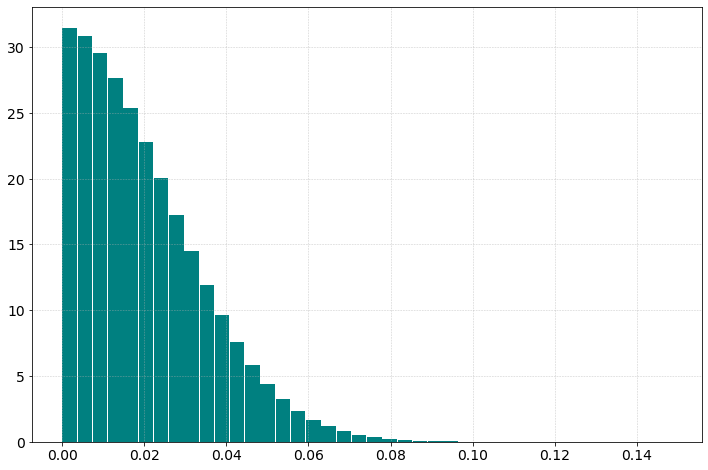

In [137]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
hist_min=np.min(mydist)
hist_max=np.max(mydist)

nbins=40
(n10_tot, bins10_tot, patches10)=ax.hist(mydist,bins=nbins,range=(hist_min,hist_max),rwidth=0.95,density=True,color='teal')

In [140]:
print('mean={} center={}'.format(np.mean(mydist),0))
print('std={} std a mano={}'.format(np.std(mydist),np.sqrt(sigx**2+sigy**2)/2))
#print('Asimmetria di Pearson={}'.format(3*(np.mean(mydist)-np.median(mydist))/(np.std(mydist))))

std=0.015219430961891458 std a mano=0.01457212772117807


In [92]:
phis=np.array([np.pi/3,np.pi/4])
thetas=np.array([np.pi/3,np.pi/4])
vecs=hp.ang2vec(thetas,phis)

In [98]:
print(np.shape(vecs))
dirs=hp.vec2dir(vecs[0])
print(dirs,thetas[0],phis[0],dirs[0]-thetas[0],dirs[1]-phis[1])

(2, 3)
[1.04719755 1.04719755] 1.0471975511965976 1.0471975511965976 0.0 0.26179938779914935


In [88]:
ds_phi_scat=np.zeros(len(phis))
ds_theta_scat=np.zeros(len(phis))

In [40]:
    for j in range(len(phis)):
        tmp_vec=random_VMF (vecs[j] , conc)
        ds_theta_scat[j],ds_phi_scat[j]=hp.vec2ang(tmp_vec)


In [41]:
ds_theta_scat

array([1.04432634, 0.77172757])

In [42]:
thetas

array([1.04719755, 0.78539816])